In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk 
from sklearn.ensemble import RandomForestClassifier 
from glob import glob,iglob
from osgeo import gdal , gdal_array
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,make_scorer
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from write_geotif import CreateGeoTiff
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

from yellowbrick.model_selection import FeatureImportances

from tqdm import tqdm
import joblib 
import earthpy.plot as ep

from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from sklearn.metrics import roc_auc_score
import numpy as np
import pickle

Data processing: to preprocess the data for some predictive modeling task, ensuring proper data types, handling categorical variables, and splitting the data into training and testing sets.

In [2]:
#Reading Data:This line reads a CSV file named "point_final.csv" into a pandas DataFrame (data_org) using pd.read_csv(). The delimiter used in the CSV file is ;.
data_org=pd.read_csv("point_final.csv",delimiter=";")

In [3]:
#Data Preprocessing:Here, a copy of the original DataFrame is created (data) to perform data preprocessing. In this step, commas in the data are replaced with periods. This is likely done to ensure consistency in representing decimal numbers.
data=data_org.copy()
data=data.replace(",",".",regex=True)

In [4]:
#Checking Data Types:This line prints out the data types of each column in the DataFrame data.
data.dtypes

OID_                  int64
Landslide             int64
LONGITUDE            object
LATITUDE             object
DTM_merged           object
slope                object
LULC                  int64
profile_curvature    object
plan_curvature       object
dist_acc_road        object
dist_river           object
NDVI                 object
rain                 object
aspect                int64
dtype: object

In [5]:
#Removing First Column:This line removes the first column from the DataFrame data. It's common in data processing tasks to remove index columns or columns that are not needed for analysis.
data=data.iloc[:,1:]

In [6]:
# Separate features and target variable: Here, the DataFrame X is created containing all the features (independent variables) except for the 'Landslide' column, while y contains only the 'Landslide' column, which is the target variable (dependent variable).
X=data.drop('Landslide', axis=1).copy()
y=data.loc[:,'Landslide'].copy()

In [7]:
X.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,LULC,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,aspect
0,91682.5802,92003.1689,373.0174866,0.787680209,4,-0.06276847,0.033129507,411.9653931,180.7027969,0.362031567,67.34322357,7
1,55682.266,104415.2486,385.8379517,16.82241821,2,-0.269385904,0.087632157,258.0426331,148.4890594,0.335763618,82.88248444,6
2,76261.6868,66915.8101,294.2075043,10.79049492,4,0.272305995,-0.318835378,580.9100647,373.3664398,0.4827781,71.41384125,8
3,56772.518,102116.9275,455.8366547,24.03018665,2,-0.174597126,0.955412209,539.9199219,80.76198578,0.265183495,82.81878662,8
4,67847.8478,81082.7308,315.7912445,2.850139856,4,0.11769855,0.001954662,138.8272247,569.63797,0.463345363,75.07782745,6


In [8]:
y.head()


0    0
1    0
2    0
3    0
4    0
Name: Landslide, dtype: int64

In [9]:
#Converting Data Types:This line converts all the columns in DataFrame X to float data type.
X=X.astype(float)
X.dtypes

LONGITUDE            float64
LATITUDE             float64
DTM_merged           float64
slope                float64
LULC                 float64
profile_curvature    float64
plan_curvature       float64
dist_acc_road        float64
dist_river           float64
NDVI                 float64
rain                 float64
aspect               float64
dtype: object

In [10]:
#Converting Categorical Variables:Here, specific columns ('aspect' and 'LULC') are converted to string data type. This might be done in preparation for one-hot encoding categorical variables.
#!!!!!uncomment when you have your aspect as categorical/factor variable fro example 1,2,3,4.....
X['aspect']=X['aspect'].astype(str)
X['LULC']=X['LULC'].astype(str)

In [11]:
#Checking Data Types: This line prints out the data type of the target variable y.
y.dtypes

dtype('int64')

In [12]:
#Identifying Categorical Columns:This line identifies categorical columns in the DataFrame X and stores their column names in the list cols_obj.
cols_obj=X.columns[X.dtypes=='object'].values.tolist()
cols_obj
#One-Hot Encoding Categorical Variables: This line performs one-hot encoding on the categorical variables identified earlier and stores the result in the DataFrame X_encoded.
X_encoded=pd.get_dummies(X,columns=cols_obj)

#Train-Test Split:This line splits the data into training and testing sets using train_test_split() function from scikit-learn. The training set comprises 70% of the data, and stratification is applied based on the target variable y.
X_train, X_test, y_train, y_test=train_test_split(X_encoded,y, random_state=6768, train_size=0.70, stratify=y)



In [13]:
cols_obj

['LULC', 'aspect']

In [14]:
X_train.shape

(799, 26)

In [15]:
X_test.shape

(343, 26)

In [16]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

__XGBOOST__: This code segment primarily focuses on training an XGBoost classifier, evaluating its performance, and optimizing its hyperparameters using grid search cross-validation. Let's break down the code step by step:
 Overall, this code trains an XGBoost classifier, evaluates its performance, visualizes the confusion matrix, and tunes its hyperparameters using grid search cross-validation to find the best combination of hyperparameters.

In [17]:
#Defining XGBoost Classifier:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=np.nan,eval_metric='aucpr', early_stopping_rounds=10,seed=42)
#Fitting the Classifier: This line trains the XGBoost classifier (clf_xgb) on the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])


[0]	validation_0-aucpr:0.85562
[1]	validation_0-aucpr:0.87215
[2]	validation_0-aucpr:0.86338
[3]	validation_0-aucpr:0.87025
[4]	validation_0-aucpr:0.89001
[5]	validation_0-aucpr:0.89830
[6]	validation_0-aucpr:0.89287
[7]	validation_0-aucpr:0.89529
[8]	validation_0-aucpr:0.89652
[9]	validation_0-aucpr:0.90158
[10]	validation_0-aucpr:0.90822
[11]	validation_0-aucpr:0.90658
[12]	validation_0-aucpr:0.90134
[13]	validation_0-aucpr:0.90312
[14]	validation_0-aucpr:0.90852
[15]	validation_0-aucpr:0.90706
[16]	validation_0-aucpr:0.90534
[17]	validation_0-aucpr:0.90504
[18]	validation_0-aucpr:0.90448
[19]	validation_0-aucpr:0.89736
[20]	validation_0-aucpr:0.89497
[21]	validation_0-aucpr:0.89505
[22]	validation_0-aucpr:0.89530
[23]	validation_0-aucpr:0.89439
[24]	validation_0-aucpr:0.89586


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
class_mapper={0:"No", 1:"Yes"}

In [19]:
class_mapper.keys()

dict_keys([0, 1])

In [20]:
class_mapper.values()

dict_values(['No', 'Yes'])

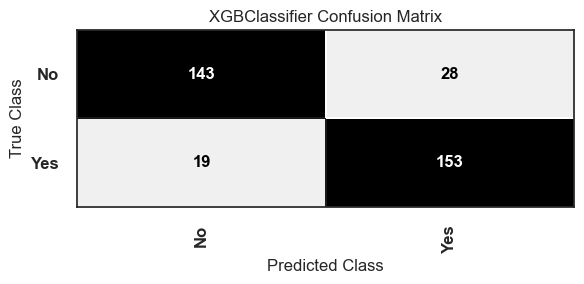

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [24]:
sns.set(style="white",font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
#This part visualizes the confusion matrix of the trained model. It plots a confusion matrix using the ConfusionMatrix function, which helps in visualizing the performance of the classifier.
fig,ax=plt.subplots(figsize=(6,3))
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()),cmap="Greys")
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show()



This code segment seems to perform several tasks after obtaining the optimal parameters through grid search cross-validation. Let's break down the steps:

In [25]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid={'max_depth':[3,4,5],
    'learning_rate':[0.1,0.05,0.01],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]}

In [26]:
#Grid Search Cross-Validation:An instance of GridSearchCV (optimal_params) is created with the XGBoost classifier as the estimator, the specified parameter grid, and other settings like verbosity, number of parallel jobs, and cross-validation folds.
optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=42,subsample=0.9,eval_metric='aucpr',early_stopping_rounds=10),
                           param_grid=param_grid,verbose=2,n_jobs=16,cv=5)

In [27]:
#Fitting the Grid Search:The fit method is called on optimal_params to perform the grid search cross-validation on the training data. The evaluation is done on the test set as well.
optimal_params.fit(X_train,y_train,
                   verbose=True,
                   eval_set=[(X_test,y_test)])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-aucpr:0.75383
[1]	validation_0-aucpr:0.75165
[2]	validation_0-aucpr:0.78445
[3]	validation_0-aucpr:0.78455
[4]	validation_0-aucpr:0.78820
[5]	validation_0-aucpr:0.78440
[6]	validation_0-aucpr:0.78089
[7]	validation_0-aucpr:0.81208
[8]	validation_0-aucpr:0.83142
[9]	validation_0-aucpr:0.84371
[10]	validation_0-aucpr:0.84680
[11]	validation_0-aucpr:0.85124
[12]	validation_0-aucpr:0.85354
[13]	validation_0-aucpr:0.86112
[14]	validation_0-aucpr:0.86464
[15]	validation_0-aucpr:0.87318
[16]	validation_0-aucpr:0.88551
[17]	validation_0-aucpr:0.88494
[18]	validation_0-aucpr:0.88591
[19]	validation_0-aucpr:0.88622
[20]	validation_0-aucpr:0.88622
[21]	validation_0-aucpr:0.88749
[22]	validation_0-aucpr:0.88948
[23]	validation_0-aucpr:0.88596
[24]	validation_0-aucpr:0.88820
[25]	validation_0-aucpr:0.88467
[26]	validation_0-aucpr:0.88292
[27]	validation_0-aucpr:0.88292
[28]	validation_0-aucpr:0.89115
[29]	validation_0-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=16,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             verbose=2)

In [28]:
#Best Parameters:This line prints out the best parameters found by the grid search cross-validation.
optimal_params.best_params_

{'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 10.0,
 'scale_pos_weight': 1}

In [29]:
#Setting up XGBoost Classifier with Optimal Parameters: Here, an instance of the XGBoost classifier (clf_xgb) is created with the optimal parameters obtained from grid search cross-validation. Additionally, other settings such as the objective function, seed, and subsample are specified.
clf_xgb=xgb.XGBClassifier(objective='binary:logistic', missing=0,eval_metric='aucpr', early_stopping_rounds=10,seed=42,
                          **optimal_params.best_params_,subsample=0.9)

In [30]:
#Fitting the Classifier and Training Set:This line fits the XGBoost classifier to the training data (X_train, y_train) and evaluates it on the test set (X_test, y_test). The verbose=True argument prints the evaluation results during training.
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.75854
[1]	validation_0-aucpr:0.77962
[2]	validation_0-aucpr:0.82349
[3]	validation_0-aucpr:0.82544
[4]	validation_0-aucpr:0.82926
[5]	validation_0-aucpr:0.82959
[6]	validation_0-aucpr:0.82510
[7]	validation_0-aucpr:0.84389
[8]	validation_0-aucpr:0.86089
[9]	validation_0-aucpr:0.85675
[10]	validation_0-aucpr:0.86276
[11]	validation_0-aucpr:0.87051
[12]	validation_0-aucpr:0.87072
[13]	validation_0-aucpr:0.87200
[14]	validation_0-aucpr:0.87461
[15]	validation_0-aucpr:0.87331
[16]	validation_0-aucpr:0.88329
[17]	validation_0-aucpr:0.88287
[18]	validation_0-aucpr:0.89001
[19]	validation_0-aucpr:0.88895
[20]	validation_0-aucpr:0.89081
[21]	validation_0-aucpr:0.89257
[22]	validation_0-aucpr:0.89242
[23]	validation_0-aucpr:0.89864
[24]	validation_0-aucpr:0.90079
[25]	validation_0-aucpr:0.90052
[26]	validation_0-aucpr:0.90036
[27]	validation_0-aucpr:0.89982
[28]	validation_0-aucpr:0.90509
[29]	validation_0-aucpr:0.90540
[30]	validation_0-aucpr:0.90732
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=0, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
X_train

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
321,49848.0878,100267.0885,404.632416,16.809582,0.135305,-0.005950,66.925327,97.977036,0.331368,84.384460,...,False,False,False,False,False,True,False,False,False,False
1115,89695.0000,90019.0000,353.415008,17.768637,-0.632733,-0.768533,70.000000,594.229767,0.450290,67.041664,...,False,False,False,False,False,True,False,False,False,False
376,82078.0651,98264.6255,306.773453,2.824122,0.013427,0.054874,30.805843,83.297642,0.501121,69.443787,...,False,False,False,True,False,False,False,False,False,False
624,56854.4194,65176.4916,400.808990,2.743535,-0.021748,-0.114540,147.492371,601.791504,0.408595,81.559036,...,False,False,True,False,False,False,False,False,False,False
575,77413.7941,81349.4616,230.217537,3.446514,0.026919,-0.146082,159.050308,245.718338,0.351439,69.168785,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,81659.0355,90147.9564,304.052490,12.033729,-0.091309,0.003311,139.846344,78.924011,0.413930,69.559464,...,False,False,False,False,False,True,False,False,False,False
1076,92989.0000,63595.0000,229.800003,19.388506,0.417075,0.466161,421.921783,258.052322,0.487769,65.642372,...,False,False,False,False,False,False,False,False,True,False
796,75383.1660,89034.8312,309.070007,1.294650,-0.069368,0.001527,444.342224,248.471329,0.319260,68.575142,...,False,False,True,False,False,False,False,False,False,False
1048,79765.0000,101829.0000,241.242897,8.725870,1.713025,-0.086424,74.632431,62.209316,0.460003,68.849998,...,False,False,False,True,False,False,False,False,False,False


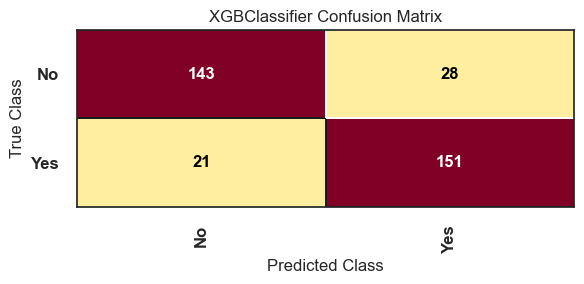

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\plots\\confusion_matrix_XGBClassifier.png'

<Figure size 800x550 with 0 Axes>

In [33]:
#Visualizing Confusion Matrix:This section visualizes the confusion matrix of the trained model using the ConfusionMatrix visualizer. It helps in understanding the model's performance in terms of true positive, true negative, false positive, and false negative predictions.
cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.values()))
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()),cmap="Greys")
fig,ax=plt.subplots(figsize=(6,3))
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
cm.show(title="XGBoost Hyperparameter Optimization for Classification")
# Save the figure to a specific directory on the C drive
plt.savefig(r'C:\plots\confusion_matrix_XGBClassifier.png', bbox_inches='tight', dpi=300)


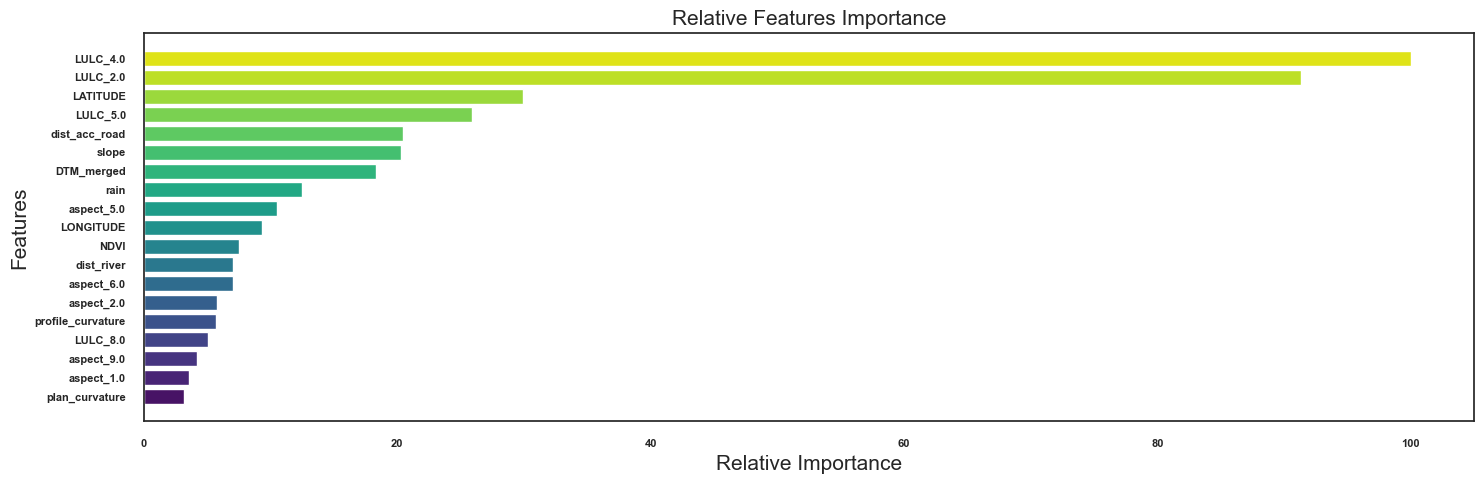

In [34]:
# Assuming clf_rf is already defined and trained
names = clf_xgb.feature_names_in_
importance_normalized = (clf_xgb.feature_importances_ / max(clf_xgb.feature_importances_)) * 100
values = importance_normalized

# Filter out features with 0 importance
importance_dic_filtered = {k: v for k, v in zip(names, values) if v > 0}
sort_id = sorted(importance_dic_filtered, key=lambda x: importance_dic_filtered[x], reverse=False)
importance_dic_filtered_sorted = {k: importance_dic_filtered[k] for k in sort_id}

# Generate a nice color palette using seaborn
num_colors = len(sort_id)
colours = sns.color_palette("viridis", num_colors)

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(list(importance_dic_filtered_sorted.keys()), list(importance_dic_filtered_sorted.values()), color=colours)

# Make font size bigger
ax.set_title("Relative Features Importance", fontsize=15)
ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Relative Importance", fontsize=15)

# Set font size for tick labels
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()

In [35]:
original_palette = sns.color_palette("Greys")

# Create a reversed version of the palette
reversed_palette = original_palette[::-1]

In [36]:
#Visualizing Classification Report: This line initializes a visualizer for generating a classification report. It provides a detailed summary of the model's performance, including precision, recall, F1-score, and support for each class
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)

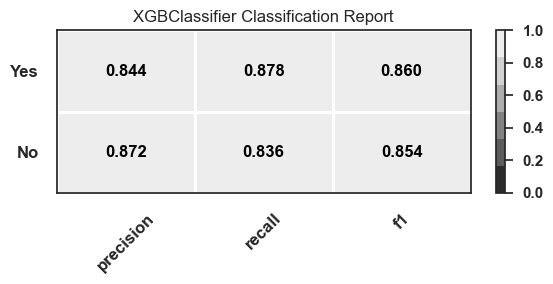

In [37]:
#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. Additionally, it saves the visualization as an image file named "accuracy_assessment.png".
visualizer = ClassificationReport(clf_xgb, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")
#cm = ConfusionMatrix(clf_xgb, classes=list(class_mapper.keys()))
fig,ax=plt.subplots(figsize=(6,3))

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="./accuracy_assessment.png")    
fig.tight_layout()

Overall, this code segment aims to provide a comprehensive assessment of the XGBoost classifier's performance, including visualizations of feature importances, confusion matrix, and a detailed classification report.

## prediction for the entire image 

This code segment is aimed at making predictions for an entire image using the trained XGBoost classifier and then saving the predicted probabilities as a GeoTIFF file. Let's break down the steps:

In [66]:
#Loading Image Files:
full_data_files=glob("F:/thesis/TEMP/project/data/*.tif")

In [67]:
full_data_files

['F:/thesis/TEMP/project/data\\aspect_clip.tif',
 'F:/thesis/TEMP/project/data\\clip_dtm.tif',
 'F:/thesis/TEMP/project/data\\dist_riv_mask.tif',
 'F:/thesis/TEMP/project/data\\DTM_merged_crop1.tif',
 'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
 'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
 'F:/thesis/TEMP/project/data\\ndvi_rescale11.tif',
 'F:/thesis/TEMP/project/data\\plan_curvature.tif',
 'F:/thesis/TEMP/project/data\\plan_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\profile_curvature.tif',
 'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip.tif',
 'F:/thesis/TEMP/project/data\\rain_clip11.tif',
 'F:/thesis/TEMP/project/data\\rain_resample11.tif',
 'F:/thesis/TEMP/project/data\\reclass_aspect111.tif',
 'F:/thesis/TEMP/project/data\\resample_lulc11.tif',
 'F:/thesis/TEMP/project/data\\river_clip.tif',
 'F:/thesis/TEMP/project/data\\road_clip.tif',
 'F:/thesis/TEMP/project/data\\road_resample.tif',
 'F:/thesis/TEMP/project/data\\slope1_cl

In [68]:
files_sorted=['F:/thesis/TEMP/project/data\\aspect_clip.tif',
            'F:/thesis/TEMP/project/data\\slope1_clip11.tif',
             'F:/thesis/TEMP/project/data\\LULC_clip11.tif',
             'F:/thesis/TEMP/project/data\\prof_cur_clip.tif',
             'F:/thesis/TEMP/project/data\\plan_cur_clip.tif',
             'F:/thesis/TEMP/project/data\\road_clip.tif',
             'F:/thesis/TEMP/project/data\\river_clip.tif',
             'F:/thesis/TEMP/project/data\\NDVI_clip.tif',
            'F:/thesis/TEMP/project/data\\rain_clip11.tif',
             'F:/thesis/TEMP/project/data\\aspect_clip.tif']


In [69]:
X_encoded.head()

,LONGITUDE,LATITUDE,DTM_merged,slope,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,...,aspect_0.0,aspect_1.0,aspect_2.0,aspect_3.0,aspect_4.0,aspect_5.0,aspect_6.0,aspect_7.0,aspect_8.0,aspect_9.0
0,91682.5802,92003.1689,373.017487,0.787680,-0.062768,0.033130,411.965393,180.702797,0.362032,67.343224,...,False,False,False,False,False,False,False,True,False,False
1,55682.2660,104415.2486,385.837952,16.822418,-0.269386,0.087632,258.042633,148.489059,0.335764,82.882484,...,False,False,False,False,False,False,True,False,False,False
2,76261.6868,66915.8101,294.207504,10.790495,0.272306,-0.318835,580.910065,373.366440,0.482778,71.413841,...,False,False,False,False,False,False,False,False,True,False
3,56772.5180,102116.9275,455.836655,24.030187,-0.174597,0.955412,539.919922,80.761986,0.265183,82.818787,...,False,False,False,False,False,False,False,False,True,False
4,67847.8478,81082.7308,315.791245,2.850140,0.117699,0.001955,138.827225,569.637970,0.463345,75.077827,...,False,False,False,False,False,False,True,False,False,False


In [70]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [71]:
#Loading Image Data:Here, each TIFF file is opened using GDAL, and its data is read as an array within a specified subset.
full_data_array=[]
subset=(0,0, 6861,4064)
for i in files_sorted:
    full_data_array.append(gdal.Open(i).ReadAsArray(*subset))

In [72]:
#temp=gdal.Open(files_sorted[3])
#temp=temp.ReadAsArray()

In [73]:
len(full_data_array)

full_data_array

[array([[8, 8, 7, ..., 6, 7, 7],
        [7, 7, 7, ..., 7, 7, 8],
        [7, 7, 7, ..., 8, 8, 8],
        ...,
        [4, 5, 5, ..., 5, 5, 5],
        [3, 3, 5, ..., 5, 5, 5],
        [3, 3, 4, ..., 5, 5, 5]], dtype=uint8),
 array([[ 3.9183056,  3.8969402,  5.0904055, ...,  6.6013646,  5.74572  ,
          4.235087 ],
        [ 3.9744542,  4.2215085,  4.864669 , ...,  6.1262007,  6.839926 ,
          6.885824 ],
        [ 4.1462955,  4.00364  ,  4.364813 , ...,  9.144788 , 12.99126  ,
         15.31868  ],
        ...,
        [ 1.1457663,  1.0299677,  1.2467928, ..., 31.265144 , 30.553839 ,
         28.113626 ],
        [ 1.1911912,  1.1861372,  1.262539 , ..., 29.263624 , 29.449186 ,
         27.376022 ],
        [ 1.4304197,  1.2343521,  1.4798325, ..., 28.215279 , 28.274544 ,
         28.312813 ]], dtype=float32),
 array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [5, 5, 5, ..., 2, 2, 2],
        [5, 5, 5, ..., 

In [74]:
#convert back to array
#np.array([full_data_array[1]]).shape # to convert 2D dimension to 3D array to make concatenation possible 
#full_data_array=np.concatenate(full_data_array, axis =1)
#Stacking Image Data: The arrays obtained from each TIFF file are stacked along a new axis to form a 3D array, representing the entire dataset.
full_data_array=np.stack(full_data_array)

In [75]:
dimension=full_data_array.shape
dimension

(10, 4064, 6861)

In [76]:
#Reshaping Image Data:The 3D array is reshaped into a 2D array for further processing.
full_data_array=full_data_array.reshape(10,(dimension[1]*dimension[2]))

In [77]:
full_data_array.shape

(10, 27883104)

In [78]:
full_data_array=full_data_array.swapaxes(0,1)
full_data_array.shape

(27883104, 10)

In [79]:
#for longitude and latitude 
meta_data=gdal.Open(files_sorted[2])

In [80]:
geotransform=meta_data.GetGeoTransform()
geotransform

(72258.87973294931, 1.0, 0.0, 88383.76677642332, 0.0, -1.000246062992126)

In [81]:
meta_data.GetProjection()

'PROJCS["LUREF_Transverse_Mercator",GEOGCS["Luxembourg 1930",DATUM["Luxembourg_1930",SPHEROID["International 1924",6378388,297.000000000005,AUTHORITY["EPSG","7022"]],AUTHORITY["EPSG","6181"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4181"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49.8333333333333],PARAMETER["central_meridian",6.16666666666667],PARAMETER["scale_factor",1],PARAMETER["false_easting",80000],PARAMETER["false_northing",100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [82]:
band_description=meta_data.GetRasterBand(1)

In [83]:
band_description.XSize

6861

In [84]:
band_description.YSize

4064

In [85]:
#Creating Longitude and Latitude Arrays: Longitude and latitude arrays are generated based on the geotransform information obtained from one of the TIFF files
long=[geotransform[0]+ i for i in range(band_description.XSize)]
lat=[ geotransform[3] -i for i in range (band_description.YSize) ]

In [86]:
len(long)

6861

In [87]:
len(lat)

4064

In [88]:
#full_data_array[100,1]

In [89]:
#full_data_array[100,2]

In [90]:
#full_data_array[100,3]

In [91]:
#np.c_[np.arange(1,10).ravel(),np.arange(100,109).ravel()]

In [92]:
#r,c=np.meshgrid(np.arange(1,10),np.arange(100,109))

In [93]:
#r
#np.c_[r.ravel(),c.ravel()]

In [94]:
xx,yy=np.meshgrid(np.array(long),np.array(lat))
#xx_yy_matrix=np.vstack((np.ravel(xx), np.ravel(yy)))
xx_yy_matrix=np.c_[xx.ravel(), yy.ravel()]

In [95]:
xx_yy_matrix.shape

(27883104, 2)

In [96]:
full_data_array.shape

(27883104, 10)

In [97]:
#Concatenating Longitude, Latitude, and Image Data:Longitude, latitude, and image data arrays are concatenated horizontally to form a single array representing the entire dataset.
full_data_array=np.hstack((xx_yy_matrix,full_data_array))

In [98]:
full_data_array.shape

(27883104, 12)

In [67]:
full_data_array[:,5]

array([ 2.0842452 , -0.12942636, -5.67899275, ..., -3.8664279 ,
       -7.55950022, -6.78891802])

In [68]:
#Converting to DataFrame and One-Hot Encoding:The concatenated array is converted to a DataFrame, and one-hot encoding is applied to categorical variables.
full_data_array_df=pd.DataFrame(full_data_array, columns=X.columns)

In [69]:
full_data_array_df

,LONGITUDE,LATITUDE,DTM_merged,slope,LULC,profile_curvature,plan_curvature,dist_acc_road,dist_river,NDVI,rain,aspect
0,72258.879733,88383.766776,8.0,3.918306,2.0,2.084245,2.084245,871.455078,500.695526,0.466146,70.125427,8.0
1,72259.879733,88383.766776,8.0,3.896940,2.0,-0.129426,-0.129426,871.690857,501.474823,0.466146,70.125427,8.0
2,72260.879733,88383.766776,7.0,5.090405,2.0,-5.678993,-5.678993,871.927734,502.254913,0.466146,70.125427,7.0
3,72261.879733,88383.766776,7.0,5.586890,2.0,-1.017010,-1.017010,872.165710,503.035797,0.466146,70.125427,7.0
4,72262.879733,88383.766776,7.0,4.758517,2.0,2.595974,2.595974,872.404724,503.817413,0.466146,70.125427,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27883099,79114.879733,84320.766776,5.0,25.854704,2.0,3.362693,3.362693,731.301575,612.437744,0.439902,69.168785,5.0
27883100,79115.879733,84320.766776,5.0,27.592419,2.0,0.186800,0.186800,730.302002,612.147888,0.439902,69.168785,5.0
27883101,79116.879733,84320.766776,5.0,28.215279,2.0,-3.866428,-3.866428,729.302429,611.859436,0.439902,69.168785,5.0
27883102,79117.879733,84320.766776,5.0,28.274544,2.0,-7.559500,-7.559500,728.302795,611.572571,0.439902,69.168785,5.0


In [70]:
full_data_array_df['aspect']=full_data_array_df['aspect'].astype(str)
full_data_array_df['LULC']=full_data_array_df['LULC'].astype(str)
cols_obj_full=full_data_array_df.columns[full_data_array_df.dtypes=='object'].values.tolist()
cols_obj_full
full_data_array_df_encoded=pd.get_dummies(full_data_array_df,columns=cols_obj_full)

In [71]:
full_data_array_df_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_6.0', 'LULC_8.0',
       'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0', 'aspect_5.0',
       'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [72]:
#full_data_array_df["LULC"].unique()

In [73]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [74]:
# List of missing columns in full_data_array_df_encoded
#missing_columns = ['LULC_0.0', 'LULC_1.0', 'LULC_3.0', 'LULC_6.0', 'LULC_7.0', 'aspect_0.0']

In [75]:
# Assuming X_encoded and full_data_array_df_encoded are your DataFrames
missing_columns = [c for c in X_encoded.columns if c not in full_data_array_df_encoded.columns]
missing_columns

['LULC_0.0', 'LULC_1.0', 'aspect_0.0']

In [76]:
# Add missing columns to full_data_array_df_encoded and fill with false
for col in missing_columns:
    full_data_array_df_encoded[col] = False

In [77]:
full_data_array_df_encoded.columns
#X_encoded.shape
#==X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_6.0', 'LULC_8.0',
       'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0', 'aspect_5.0',
       'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0', 'LULC_0.0',
       'LULC_1.0', 'aspect_0.0'],
      dtype='object')

In [78]:
#filter/subset columns to confrom with ur training data
#Columns in the DataFrame are filtered to match those used during training, and their order is rearranged accordingly.
full_data_array_df_encoded=full_data_array_df_encoded[X_encoded.columns]

In [79]:
# Reordering columns to match the model's feature order
full_data_array_df_encoded = full_data_array_df_encoded[X_encoded.columns]

In [80]:
#np.all(full_data_array_df_encoded.columns==X_encoded.columns)


In [81]:
X_encoded.columns

Index(['LONGITUDE', 'LATITUDE', 'DTM_merged', 'slope', 'profile_curvature',
       'plan_curvature', 'dist_acc_road', 'dist_river', 'NDVI', 'rain',
       'LULC_0.0', 'LULC_1.0', 'LULC_2.0', 'LULC_4.0', 'LULC_5.0', 'LULC_8.0',
       'aspect_0.0', 'aspect_1.0', 'aspect_2.0', 'aspect_3.0', 'aspect_4.0',
       'aspect_5.0', 'aspect_6.0', 'aspect_7.0', 'aspect_8.0', 'aspect_9.0'],
      dtype='object')

In [82]:
# Making predictions using the XGBoost model
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions = clf_xgb.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ=predictions[:,1]
#Reshaping Predictions:The predicted probabilities are reshaped to match the dimensions of the original image.
l=predictions_occ.reshape(dimension[1:])

In [83]:
predictions_occ

array([0.41964844, 0.3651611 , 0.35370594, ..., 0.61131996, 0.61131996,
       0.61131996], dtype=float32)

In [84]:
dimension[1]*dimension[2]

27883104

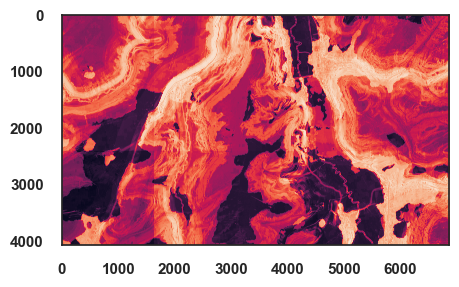

In [85]:
fig,ax=plt.subplots(figsize=(5,5))
plt.imshow(l)

In [86]:
"""
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        DataSet.GetRasterBand(i).WriteArray( image )
        DataSet.GetRasterBand(i).SetNoDataValue(NDV)
        DataSet.SetDescription(bandnames[i-1])
    DataSet.FlushCache()
    return Name
"""

"\ndef CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, \n                  GeoT=None, Projection=None):\n    # If it's a 2D image we fake a third dimension:\n    if len(Array.shape)==2:\n        Array=np.array([Array])\n    if ref_image==None and (GeoT==None or Projection==None):\n        raise RuntimeWarning('ref_image or settings required.')\n    if bandnames != None:\n        if len(bandnames) != Array.shape[0]:\n            raise RuntimeError('Need {} bandnames. {} given'\n                               .format(Array.shape[0],len(bandnames)))\n    else:\n        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]\n    if ref_image!= None:\n        refimg=gdal.Open(ref_image)\n        GeoT=refimg.GetGeoTransform()\n        Projection=refimg.GetProjection()\n    driver= gdal.GetDriverByName('GTIFF')\n    Array[np.isnan(Array)] = NDV\n    DataSet = driver.Create(Name, \n            Array.shape[2], Array.shape[1], Array.shape[0], DataType)\n    Data

In [87]:
gdal_type=gdal_array.NumericTypeCodeToGDALTypeCode(l.dtype)
gdal_type

6

In [88]:
#Saving Predictions as GeoTIFF:
CreateGeoTiff("F:/thesis/TEMP/project/classification/test_xgboost.tif",l,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

'F:/thesis/TEMP/project/classification/test_xgboost.tif'

Finally, the predicted probabilities are saved as a GeoTIFF file using the provided function CreateGeoTiff. This GeoTIFF file can be further processed or visualized using GIS software.

## RandomForest

Define Random Forest Classifier

In [89]:
clf_rf = RandomForestClassifier(random_state=42)

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


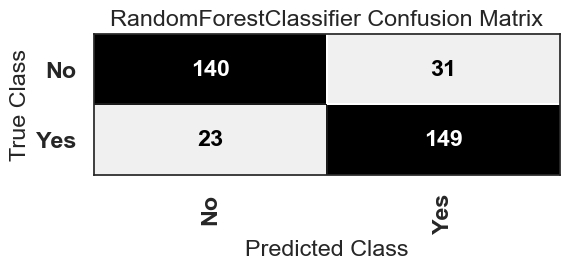

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [90]:
#Train the Classifier
# Fitting the classifier to the training data
clf_rf.fit(X_train, y_train)

# Customizing seaborn plot style and scale
sns.set(style="white", font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")

# Visualizing the confusion matrix using Yellowbrick
fig, ax = plt.subplots(figsize=(6, 3))
cm_rf = ConfusionMatrix(clf_rf, classes=list(class_mapper.values()), cmap="Greys")

# Fit with the training data
cm_rf.fit(X_train, y_train)

# Score with the test data
cm_rf.score(X_test, y_test)

# Show the plot
cm_rf.show()


In [91]:
#Hyperparameter Tuning with Grid Search: Here, a dictionary param_grid is defined, which contains the hyperparameters and their respective values to be tuned.
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [92]:
# Grid Search Cross-Validation
optimal_params_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                 param_grid=param_grid_rf, verbose=2, n_jobs=16, cv=5)

In [93]:
# Fit the grid search to the data
optimal_params_rf.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=16,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [94]:
# Best Parameters
print("Best parameters found: ", optimal_params_rf.best_params_)

Best parameters found:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


Setting up Random Forest Classifier with Optimal Parameters: Let's create an instance of the Random Forest classifier using the best parameters found by the grid search.

In [95]:
# Train the Random Forest classifier
clf_rf = optimal_params_rf.best_estimator_


In [96]:
# Customizing seaborn plot style and scale
sns.set(style="white", font_scale=1.4, rc={"font.weight": "bold"})
sns.set_style(style="white")

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


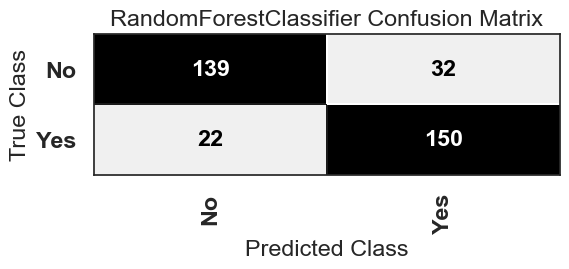

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [97]:
# Visualizing the confusion matrix using Yellowbrick
fig, ax = plt.subplots(figsize=(6, 3))

cm_rf = ConfusionMatrix(clf_rf, classes=list(class_mapper.values()), cmap="Greys", ax=ax)
cm_rf.fit(X_train, y_train)
cm_rf.score(X_test, y_test)

cm_rf.show()

C:\TEMP\thesis\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


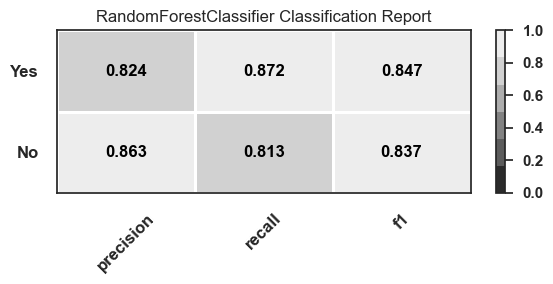

In [98]:
#Fitting and Displaying the Classification Report:This section fits the visualizer to the training data, evaluates it on the test data, and then displays the classification report. 
#Additionally, it saves the visualization as an image file named "accuracy_assessment.png".
visualizer_rf = ClassificationReport(clf_rf, classes=list(class_mapper.values()), support=False,cmap=reversed_palette)
sns.set(style="white",font_scale=1, rc={"font.weight": "bold"})
sns.set_style(style="white")
fig,ax=plt.subplots(figsize=(6,3))
visualizer_rf.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer_rf.score(X_test, y_test)        # Evaluate the model on the test data
visualizer_rf.show(outpath="./accuracy_assessment_random_forest.png")    
fig.tight_layout()

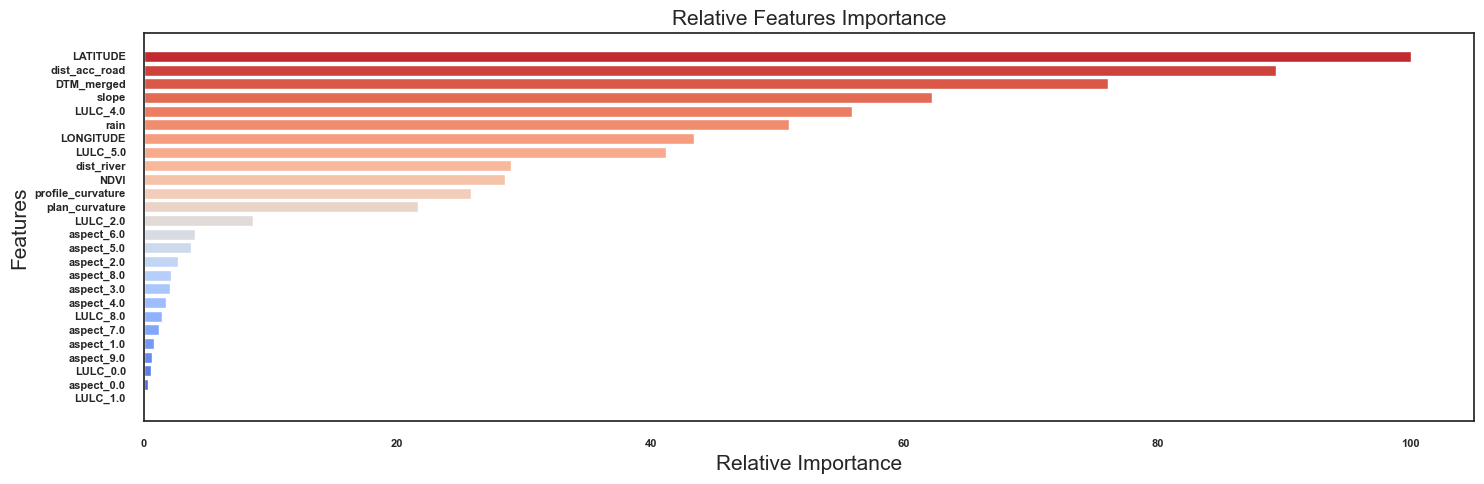

In [99]:
# Assuming clf_rf is already defined and trained
names = clf_rf.feature_names_in_
importance_normalized = (clf_rf.feature_importances_ / max(clf_rf.feature_importances_)) * 100
values = importance_normalized

# Filter out features with 0 importance
importance_dic_filtered = {k: v for k, v in zip(names, values) if v > 0}
sort_id = sorted(importance_dic_filtered, key=lambda x: importance_dic_filtered[x], reverse=False)
importance_dic_filtered_sorted = {k: importance_dic_filtered[k] for k in sort_id}

# Generate a nice color palette using seaborn
num_colors = len(sort_id)
colours = sns.color_palette("coolwarm", num_colors)

fig, ax = plt.subplots(figsize=(15, 5))
ax.barh(list(importance_dic_filtered_sorted.keys()), list(importance_dic_filtered_sorted.values()), color=colours)

# Make font size bigger
ax.set_title("Relative Features Importance", fontsize=15)
ax.set_ylabel("Features", fontsize=15)
ax.set_xlabel("Relative Importance", fontsize=15)

# Set font size for tick labels
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()

Making predictions using the Random Forest model

In [100]:
#predictions = clf_xgb.predict(full_data_array_df_encoded)
predictions_rf = clf_rf.predict_proba(full_data_array_df_encoded)
#probability of occurence 
predictions_occ_rf=predictions[:,1]
l_rf=predictions_occ_rf.reshape(dimension[1:])

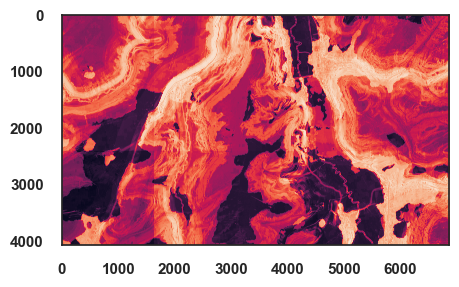

In [101]:
fig,ax=plt.subplots(figsize=(5,5))
plt.imshow(l_rf)

In [102]:
CreateGeoTiff("./classification/test_rf.tif",l_rf,gdal_type,-9999,["Band_1"],GeoT=meta_data.GetGeoTransform(),Projection=meta_data.GetProjection())

'./classification/test_rf.tif'

__NGBoost__

In [103]:
import os

In [104]:
os.getcwd()

'C:\\temp\\project'

In [141]:
# Defining the NGBoost Classifier
clf_ngb = NGBClassifier(Dist=Bernoulli, 
                        verbose=True, 
                        random_state=42,
                        natural_gradient=True)

In [142]:
# Fitting the classifier
clf_ngb.fit(X_train, y_train, 
            X_val=X_test, Y_val=y_test,
            early_stopping_rounds=10)

[iter 0] loss=0.6930 val_loss=0.6706 scale=4.0000 norm=8.0000
[iter 100] loss=0.1848 val_loss=0.3165 scale=1.0000 norm=1.2977
== Early stopping achieved.
== Best iteration / VAL133 (val_loss=0.3140)


NGBClassifier(random_state=RandomState(MT19937) at 0x2A361544840)

[iter 0] loss=0.6930 val_loss=0.6706 scale=4.0000 norm=8.0000
[iter 100] loss=0.1848 val_loss=0.3165 scale=1.0000 norm=1.2977
== Early stopping achieved.
== Best iteration / VAL133 (val_loss=0.3141)


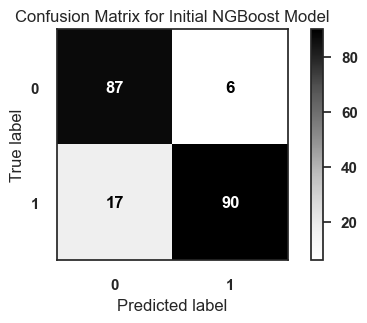


Classification Report for Initial NGBoost Model:
               precision    recall  f1-score   support

           0       0.84      0.94      0.88        93
           1       0.94      0.84      0.89       107

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.89       200



In [132]:

# Initial NGBoost Classifier without hyperparameter tuning
clf_ngb_initial = NGBClassifier(Dist=Bernoulli, Score=LogScore, verbose=True, random_state=42)

# Fitting the initial classifier
clf_ngb_initial.fit(X_train, y_train, X_val=X_test, Y_val=y_test, early_stopping_rounds=10)

# Making predictions
y_pred_initial = clf_ngb_initial.predict(X_test)

# Define class labels manually
class_labels = np.unique(y)  # Assuming y contains all possible class labels

# Compute Confusion Matrix for initial model
cm_initial = confusion_matrix(y_test, y_pred_initial, labels=class_labels)

# Plot confusion matrix for the initial model
fig, ax = plt.subplots(figsize=(6, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_initial, display_labels=class_labels)
disp.plot(cmap="Greys", ax=ax)
plt.title('Confusion Matrix for Initial NGBoost Model')
plt.show()

# Print classification report for the initial model
print("\nClassification Report for Initial NGBoost Model:\n", classification_report(y_test, y_pred_initial, target_names=[str(label) for label in class_labels]))

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore
from sklearn.datasets import make_classification

In [128]:
# Define parameter grid for NGBoost
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'minibatch_frac': [1.0, 0.5, 0.1]
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\TEMP\thesis\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
33 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "C:\TEMP\thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\TEMP\thesis\lib\site-packages\ngboost\ngboost.py", line 250, in fit
    return self.partial_fit(
  File "C:\TEMP\thesis\lib\site-packages\ngboost\ngboost.py", line 383, in partial_fit
    grads = D.grad(Y_batch, natural=self.natural_gradient)
  File "C:\TEMP\thesis\lib\site-packages\ngboost\scores.py", line 12, in gra

[iter 0] loss=0.6924 val_loss=0.0000 scale=8.0000 norm=15.9909
[iter 100] loss=0.1183 val_loss=0.0000 scale=1.0000 norm=1.2244
[iter 200] loss=0.1209 val_loss=0.0000 scale=0.2500 norm=0.3092
Best parameters found:  {'learning_rate': 0.05, 'minibatch_frac': 0.5, 'n_estimators': 300}
[iter 0] loss=0.6924 val_loss=0.4979 scale=8.0000 norm=15.9909
== Early stopping achieved.
== Best iteration / VAL16 (val_loss=0.3163)


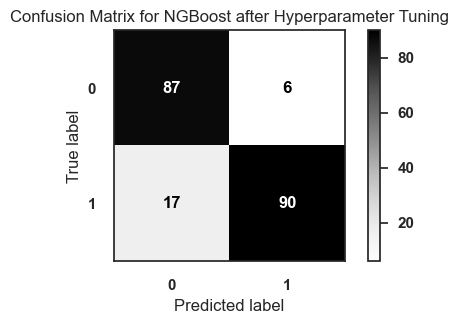


Classification Report for Tuned NGBoost Model:
               precision    recall  f1-score   support

           0       0.84      0.94      0.88        93
           1       0.94      0.84      0.89       107

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.89       200



In [134]:
# Initialize NGBoost with default settings
ngb = NGBClassifier(Dist=Bernoulli, Score=LogScore, verbose=True, random_state=42)
optimal_params = GridSearchCV(estimator=ngb, param_grid=param_grid, verbose=2, n_jobs=-1, cv=3)

# Fit grid search
optimal_params.fit(X_train, y_train)

# Best Parameters
print("Best parameters found: ", optimal_params.best_params_)

# Setting up NGBoost Classifier with Optimal Parameters
clf_ngb_tuned = NGBClassifier(**optimal_params.best_params_, Dist=Bernoulli, Score=LogScore, verbose=True, random_state=42)

# Fitting the classifier to training data
clf_ngb_tuned.fit(X_train, y_train, X_val=X_test, Y_val=y_test, early_stopping_rounds=10)

# Making predictions
y_pred_tuned = clf_ngb_tuned.predict(X_test)

# Compute Confusion Matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned, labels=class_labels)

# Plot confusion matrix for the tuned model
fig, ax = plt.subplots(figsize=(6, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=class_labels)
disp.plot(cmap="Greys", ax=ax)
plt.title('Confusion Matrix for NGBoost after Hyperparameter Tuning')
plt.show()

# Print classification report for the tuned model
print("\nClassification Report for Tuned NGBoost Model:\n", classification_report(y_test, y_pred_tuned, target_names=[str(label) for label in class_labels]))

In [143]:
# Assuming clf_rf is already defined and trained
names = clf_xgb.feature_names_in_
importance_normalized = (cm_initial.feature_importances_ / max(cm_initial.feature_importances_)) * 100
values = importance_normalized

AttributeError: 'numpy.ndarray' object has no attribute 'feature_importances_'

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load sample data
data = load_iris()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model to a .sav file
filename = 'finalized_model.sav'
joblib.dump(model, filename)

# Load the model to confirm it works
loaded_model = joblib.load(filename)
predictions = loaded_model.predict(X_test)
print(predictions)